# Project 4 : Anticipate the needs in building consumption

***

Ce notebook a été créé afin de pouvoir prédire la consommation totale d'énergie des bâtiments (et non plus la consommation en émissions CO2). Pour plus d'explications et de précisions, voir le notebook sur la consommation en émission CO2.

# Python libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
import folium
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
pd.options.mode.chained_assignment = None  # default='warn'
import plotly.express as px

#import missingno as msno
#import random

# set the style of the plots
plt.style.use('seaborn-darkgrid')

# Copy/Paste if you need to display more columns in the output
#pd.options.display.max_columns = None

# Read CSV files and content overview

In [2]:
seattle_data = pd.read_csv('seattle_data.csv')
seattle_data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,CouncilDistrictCode,...,Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,0659000030,7,...,3946027.0,1276453.0,False,Compliant,249.98,2.83,89,0.0,88434.0,7369.50
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,0659000220,7,...,3242851.0,5145082.0,False,Compliant,295.86,2.86,20,15.0,103566.0,9415.09
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,0659000475,7,...,49526664.0,1493800.0,False,Compliant,2089.28,2.19,47,21.0,956110.0,23319.76
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,0659000640,7,...,2768924.0,1811213.0,False,Compliant,286.43,4.67,90,0.0,61320.0,6132.00
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,0659000970,7,...,5368607.0,8803998.0,False,Compliant,505.01,2.88,36,35.0,175580.0,9754.44


# Selection features for the Machine Learning model

En se basant sur l'énoncé du projet :

<blockquote> <div class="alert alert-block alert-info">
    Votre prédiction se basera sur les <b>données structurelles</b> des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)
</div> </blockquote>

Pour la construction de notre modèle, on gardera donc les colonnes suivantes :
- BuildingType
- PrimaryPropertyType
- Neighborhood
- Latitude and Longitude
- PropertyGFATotal ou LargestPropertyUseTypeGFA
- LargestPropertyUseType
- BuildingAge
- NumberofBuildings
- NumberofFloors

Les deux variables cibles :

- SiteEUI(kBtu/sf)
- TotalGHGEmissions

In [3]:
len(seattle_data.NumberofBuildings.unique())

15

In [4]:
seattle_data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'BuildingAge',
       'GFABuilding(s)Pct', 'GFAperBuilding', 'GFAperFloor'],
      dtype='object')

In [5]:
corr = seattle_data.corr()
corr.style.background_gradient(cmap='coolwarm')

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,OSEBuildingID,DataYear,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor
OSEBuildingID,1.000000,nan,-0.180555,0.029341,0.105196,0.011883,0.047889,-0.283593,-0.147667,-0.229716,-0.120242,-0.108139,-0.051315,-0.010457,-0.051944,-0.090297,-0.012916,-0.104164,-0.074211,nan,-0.076510,0.083243,-0.011883,-0.200532,-0.297971,0.022308
DataYear,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CouncilDistrictCode,-0.180555,nan,1.000000,0.512255,-0.345700,-0.033093,-0.019748,0.308005,0.106702,0.192644,0.082903,0.067324,0.131836,0.067756,0.094523,0.045110,0.005608,0.071066,-0.012176,nan,0.008811,-0.011409,0.033093,0.218708,0.191178,-0.024781
Latitude,0.029341,nan,0.512255,1.000000,-0.081585,0.086482,0.021126,0.001490,0.005343,0.039460,-0.000304,0.005524,0.048837,0.089033,0.087193,0.008619,-0.005992,0.010809,0.000504,nan,-0.000978,0.039896,-0.086482,0.116476,-0.020485,0.011672
Longitude,0.105196,nan,-0.345700,-0.081585,1.000000,0.011794,0.023024,-0.018315,0.027216,-0.022636,0.031872,0.035108,-0.024680,-0.008907,-0.008672,0.040929,0.025430,0.030700,0.040600,nan,0.047195,0.010157,-0.011794,-0.057612,-0.001365,0.035517
YearBuilt,0.011883,nan,-0.033093,0.086482,0.011794,1.000000,-0.030318,0.105082,0.103567,0.290092,0.065058,0.068100,-0.047970,0.139891,0.174340,0.067705,-0.002251,0.078734,0.061211,nan,0.054414,0.001159,-1.000000,0.356076,0.215845,-0.014328
NumberofBuildings,0.047889,nan,-0.019748,0.021126,0.023024,-0.030318,1.000000,-0.022478,0.741581,-0.013675,0.778299,0.802634,-0.047307,0.029009,0.025388,0.715351,0.408926,0.760023,0.062914,nan,0.419741,0.028636,0.030318,-0.022836,-0.019553,0.915131
NumberofFloors,-0.283593,nan,0.308005,0.001490,-0.018315,0.105082,-0.022478,1.000000,0.442324,0.538783,0.382489,0.364936,0.149818,0.021949,0.064071,0.238236,0.100410,0.304877,0.037950,nan,0.140747,-0.052623,-0.105082,0.204008,0.729956,-0.036094
PropertyGFATotal,-0.147667,nan,0.106702,0.005343,0.027216,0.103567,0.741581,0.442324,1.000000,0.377277,0.990377,0.977699,0.141843,0.031077,0.050818,0.809450,0.455679,0.867813,0.153966,nan,0.527265,-0.010824,-0.103567,0.134668,0.610765,0.813096
PropertyGFAParking,-0.229716,nan,0.192644,0.039460,-0.022636,0.290092,-0.013675,0.538783,0.377277,1.000000,0.245476,0.274695,0.116157,0.046471,0.092231,0.142809,-0.000470,0.197786,0.026580,nan,0.055441,-0.099096,-0.290092,0.669772,0.627769,0.005959


In [6]:
seattle_ML = seattle_data.loc[:, ['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
                                  'Neighborhood', 'Latitude', 'Longitude', 'BuildingAge', 'GFABuilding(s)Pct',
                                  'GFAperBuilding', 'GFAperFloor', 'SiteEUI(kBtu/sf)', 'TotalGHGEmissions',
                                  'ENERGYSTARScore']]
seattle_ML.head()

,BuildingType,PrimaryPropertyType,LargestPropertyUseType,Neighborhood,Latitude,Longitude,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor,SiteEUI(kBtu/sf),TotalGHGEmissions,ENERGYSTARScore
0,NonResidential,Hotel,Hotel,Downtown,47.61220,-122.33799,89,0.0,88434.0,7369.50,81.699997,249.98,60.0
1,NonResidential,Hotel,Hotel,Downtown,47.61317,-122.33393,20,15.0,103566.0,9415.09,94.800003,295.86,61.0
2,NonResidential,Hotel,Hotel,Downtown,47.61393,-122.33810,47,21.0,956110.0,23319.76,96.000000,2089.28,43.0
3,NonResidential,Hotel,Hotel,Downtown,47.61412,-122.33664,90,0.0,61320.0,6132.00,110.800003,286.43,56.0
4,NonResidential,Hotel,Hotel,Downtown,47.61375,-122.34047,36,35.0,175580.0,9754.44,114.800003,505.01,75.0


In [7]:
seattle_ML = seattle_ML.loc[~seattle_ML.ENERGYSTARScore.isna()]

In [8]:
corr = seattle_ML.corr()
corr.style.background_gradient(cmap='coolwarm')

,Latitude,Longitude,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor,SiteEUI(kBtu/sf),TotalGHGEmissions,ENERGYSTARScore
Latitude,1.000000,-0.085438,-0.105815,0.125650,-0.029175,-0.050207,0.113399,-0.014723,0.048837
Longitude,-0.085438,1.000000,0.037558,-0.088283,-0.009673,0.046708,0.009784,0.055721,-0.024680
BuildingAge,-0.105815,0.037558,1.000000,-0.380499,-0.229075,-0.161998,-0.137459,-0.059979,0.047970
GFABuilding(s)Pct,0.125650,-0.088283,-0.380499,1.000000,0.259418,-0.021826,0.145315,-0.011479,0.022219
GFAperBuilding,-0.029175,-0.009673,-0.229075,0.259418,1.000000,0.233638,0.017658,0.198167,0.167332
GFAperFloor,-0.050207,0.046708,-0.161998,-0.021826,0.233638,1.000000,0.046629,0.241027,0.010013
SiteEUI(kBtu/sf),0.113399,0.009784,-0.137459,0.145315,0.017658,0.046629,1.000000,0.255854,-0.335584
TotalGHGEmissions,-0.014723,0.055721,-0.059979,-0.011479,0.198167,0.241027,0.255854,1.000000,-0.103341
ENERGYSTARScore,0.048837,-0.024680,0.047970,0.022219,0.167332,0.010013,-0.335584,-0.103341,1.000000


# Categorical features encoding

- Use get_dummies, TargetEncoding or OneHotEncoder to convert categorical features into numerical features before using them for our ML's model.

NB : When OneHotEncoder is instantiated with drop=’first’, one of the dummy feature is dropped. This is because the value of remaining features when all 0’s will represent the dummy feature which got dropped. This is used to avoid multi-collinearity which can be an issue for certain methods (for instance, methods that require matrix inversion).

In [9]:
seattle_ML.shape

(1003, 13)

### Using LabelEncoder from sklearn

In [10]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [11]:
seattle_ML.head()

,BuildingType,PrimaryPropertyType,LargestPropertyUseType,Neighborhood,Latitude,Longitude,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor,SiteEUI(kBtu/sf),TotalGHGEmissions,ENERGYSTARScore
0,NonResidential,Hotel,Hotel,Downtown,47.61220,-122.33799,89,0.0,88434.0,7369.50,81.699997,249.98,60.0
1,NonResidential,Hotel,Hotel,Downtown,47.61317,-122.33393,20,15.0,103566.0,9415.09,94.800003,295.86,61.0
2,NonResidential,Hotel,Hotel,Downtown,47.61393,-122.33810,47,21.0,956110.0,23319.76,96.000000,2089.28,43.0
3,NonResidential,Hotel,Hotel,Downtown,47.61412,-122.33664,90,0.0,61320.0,6132.00,110.800003,286.43,56.0
4,NonResidential,Hotel,Hotel,Downtown,47.61375,-122.34047,36,35.0,175580.0,9754.44,114.800003,505.01,75.0


In [12]:
print('Nombre de modalités de chaque variable catégorielle avant encodage')
print('PrimaryPropertyType :', len(seattle_ML.PrimaryPropertyType.unique()))
print('LargestPropertyUseType :', len(seattle_ML.LargestPropertyUseType.unique()))

Nombre de modalités de chaque variable catégorielle avant encodage
PrimaryPropertyType : 16
LargestPropertyUseType : 21


In [13]:
# Use LabelEncoder on PrimaryPropertyType and LargestPropertyUseType
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
le = LabelEncoder()

seattle_ML = MultiColumnLabelEncoder(columns = ['PrimaryPropertyType', 'LargestPropertyUseType']).fit_transform(seattle_ML)
seattle_ML.head()

,BuildingType,PrimaryPropertyType,LargestPropertyUseType,Neighborhood,Latitude,Longitude,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor,SiteEUI(kBtu/sf),TotalGHGEmissions,ENERGYSTARScore
0,NonResidential,2,6,Downtown,47.61220,-122.33799,89,0.0,88434.0,7369.50,81.699997,249.98,60.0
1,NonResidential,2,6,Downtown,47.61317,-122.33393,20,15.0,103566.0,9415.09,94.800003,295.86,61.0
2,NonResidential,2,6,Downtown,47.61393,-122.33810,47,21.0,956110.0,23319.76,96.000000,2089.28,43.0
3,NonResidential,2,6,Downtown,47.61412,-122.33664,90,0.0,61320.0,6132.00,110.800003,286.43,56.0
4,NonResidential,2,6,Downtown,47.61375,-122.34047,36,35.0,175580.0,9754.44,114.800003,505.01,75.0


In [14]:
print('Nombre de modalités de chaque variable catégorielle après encodage')
print('PrimaryPropertyType :', len(seattle_ML.PrimaryPropertyType.unique()))
print('LargestPropertyUseType :', len(seattle_ML.LargestPropertyUseType.unique()))

Nombre de modalités de chaque variable catégorielle après encodage
PrimaryPropertyType : 16
LargestPropertyUseType : 21


### Using get_dummies from pandas

In [15]:
# Use get_dummies on BuildingType and Neighborhood

seattle_ML = pd.get_dummies(seattle_ML, columns=['BuildingType', 'Neighborhood'])
seattle_ML.head()

,PrimaryPropertyType,LargestPropertyUseType,Latitude,Longitude,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor,SiteEUI(kBtu/sf),TotalGHGEmissions,...,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,Neighborhood_Northwest,Neighborhood_Southeast,Neighborhood_Southwest
0,2,6,47.61220,-122.33799,89,0.0,88434.0,7369.50,81.699997,249.98,...,1,0,0,0,0,0,0,0,0,0
1,2,6,47.61317,-122.33393,20,15.0,103566.0,9415.09,94.800003,295.86,...,1,0,0,0,0,0,0,0,0,0
2,2,6,47.61393,-122.33810,47,21.0,956110.0,23319.76,96.000000,2089.28,...,1,0,0,0,0,0,0,0,0,0
3,2,6,47.61412,-122.33664,90,0.0,61320.0,6132.00,110.800003,286.43,...,1,0,0,0,0,0,0,0,0,0
4,2,6,47.61375,-122.34047,36,35.0,175580.0,9754.44,114.800003,505.01,...,1,0,0,0,0,0,0,0,0,0


In [16]:
seattle_ML.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1003 entries, 0 to 1542
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PrimaryPropertyType                 1003 non-null   int64  
 1   LargestPropertyUseType              1003 non-null   int64  
 2   Latitude                            1003 non-null   float64
 3   Longitude                           1003 non-null   float64
 4   BuildingAge                         1003 non-null   int64  
 5   GFABuilding(s)Pct                   1003 non-null   float64
 6   GFAperBuilding                      1003 non-null   float64
 7   GFAperFloor                         1003 non-null   float64
 8   SiteEUI(kBtu/sf)                    1003 non-null   float64
 9   TotalGHGEmissions                   1003 non-null   float64
 10  ENERGYSTARScore                     1003 non-null   float64
 11  BuildingType_Campus                 1003 no

In [17]:
seattle_ML.corr().style.background_gradient(cmap='coolwarm')

,PrimaryPropertyType,LargestPropertyUseType,Latitude,Longitude,BuildingAge,GFABuilding(s)Pct,GFAperBuilding,GFAperFloor,SiteEUI(kBtu/sf),TotalGHGEmissions,ENERGYSTARScore,BuildingType_Campus,BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_SPS-District K-12,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,Neighborhood_Northwest,Neighborhood_Southeast,Neighborhood_Southwest
PrimaryPropertyType,1.000000,0.616414,-0.007131,-0.016658,0.157575,-0.255192,-0.347381,-0.079011,-0.075544,-0.179252,-0.079328,-0.076342,0.103136,0.002429,-0.107988,0.120374,0.002688,0.002407,-0.251336,-0.032214,0.144798,-0.059945,0.026128,0.050399,0.010562,0.059650,0.061798,0.082518
LargestPropertyUseType,0.616414,1.000000,0.173585,-0.025598,0.033399,-0.085280,-0.085645,-0.036070,0.057617,-0.112139,0.029723,-0.056910,0.095293,-0.018838,-0.089484,0.104983,0.002544,-0.010677,-0.100946,-0.020178,-0.185909,-0.023920,0.026257,0.069495,0.134467,0.095107,0.103904,0.134360
Latitude,-0.007131,0.173585,1.000000,-0.085438,-0.105815,0.125650,-0.029175,-0.050207,0.113399,-0.014723,0.048837,-0.002023,-0.012653,-0.043108,0.065075,0.221308,-0.036478,-0.271081,-0.101878,-0.014081,-0.567104,0.133571,0.126703,0.363960,0.313334,0.469034,-0.203726,-0.166828
Longitude,-0.016658,-0.025598,-0.085438,1.000000,0.037558,-0.088283,-0.009673,0.046708,0.009784,0.055721,-0.024680,0.091689,-0.046280,0.047293,-0.045398,-0.370359,0.211147,-0.172953,-0.067539,0.156172,0.163616,-0.070498,-0.402415,0.164409,0.398096,-0.101293,0.328885,-0.298725
BuildingAge,0.157575,0.033399,-0.105815,0.037558,1.000000,-0.380499,-0.229075,-0.161998,-0.137459,-0.059979,0.047970,-0.017287,0.066836,-0.071080,-0.022809,-0.025915,0.019884,-0.050311,0.248315,0.093781,0.043984,-0.169529,-0.150484,-0.066518,-0.038739,-0.059511,-0.054014,-0.003308
GFABuilding(s)Pct,-0.255192,-0.085280,0.125650,-0.088283,-0.380499,1.000000,0.259418,-0.021826,0.145315,-0.011479,0.022219,-0.035885,0.028641,0.027772,-0.045460,-0.020630,-0.072734,-0.079130,0.064922,0.034105,-0.227948,0.283771,0.135419,-0.037295,-0.016551,-0.072888,-0.035001,-0.055034
GFAperBuilding,-0.347381,-0.085645,-0.029175,-0.009673,-0.229075,0.259418,1.000000,0.233638,0.017658,0.198167,0.167332,0.004331,-0.054526,0.075046,0.009288,-0.073517,-0.058352,-0.042671,0.346331,-0.013581,-0.127103,0.025594,-0.050395,-0.030205,-0.079449,-0.077068,-0.047320,-0.048054
GFAperFloor,-0.079011,-0.036070,-0.050207,0.046708,-0.161998,-0.021826,0.233638,1.000000,0.046629,0.241027,0.010013,0.043516,-0.083489,-0.012335,0.112262,-0.017011,-0.029461,0.072352,-0.157473,0.010169,0.168089,-0.035224,-0.059961,0.057246,-0.010719,0.065671,0.005631,-0.009082
SiteEUI(kBtu/sf),-0.075544,0.057617,0.113399,0.009784,-0.137459,0.145315,0.017658,0.046629,1.000000,0.255854,-0.335584,0.016095,0.016217,0.002184,-0.041030,0.049832,-0.002092,0.001941,-0.014332,0.042226,-0.151138,0.026917,0.012581,0.007361,0.109372,0.003948,0.009281,0.012169
TotalGHGEmissions,-0.179252,-0.112139,-0.014723,0.055721,-0.059979,-0.011479,0.198167,0.241027,0.255854,1.000000,-0.103341,0.269543,-0.128751,-0.003225,-0.002956,-0.011278,0.006876,-0.022109,0.018478,0.134826,-0.029080,-0.027732,-0.040451,-0.019633,0.007266,-0.004844,-0.013829,-0.005733


# Prediction de la consommation totale d'énergie

In [18]:
seattle_ML = seattle_ML[~(seattle_ML['SiteEUI(kBtu/sf)'] < 1)]

In [19]:
X_cols = seattle_ML.drop(['SiteEUI(kBtu/sf)', 'TotalGHGEmissions'], axis=1).columns
y_col = 'SiteEUI(kBtu/sf)'

X = seattle_ML.drop(['SiteEUI(kBtu/sf)', 'TotalGHGEmissions'], axis=1).values
y = seattle_ML['SiteEUI(kBtu/sf)'].values

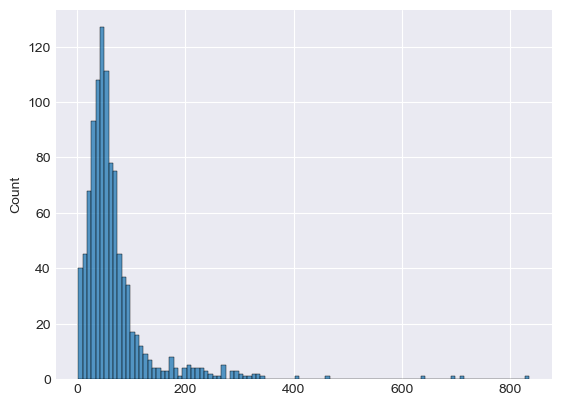

In [20]:
sns.histplot(data=seattle_ML, x=y)
plt.show()

In [21]:
y_log = np.log(y)

In [22]:
np.sort(y_log)

array([0.7419373 , 0.8329091 , 1.25276297, ..., 6.54348012, 6.56145489,
       6.72671293])

Les propriétés d'une distribution normale sont : La fonction de densité de probabilités de la loi normale a la forme d'une courbe en cloche symétrique. la moyenne et la médiane sont égales ; la courbe est centrée sur la moyenne.

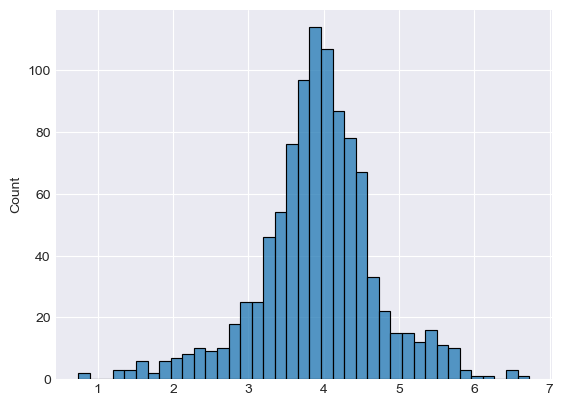

In [23]:
sns.histplot(data=seattle_ML, x=y_log)
plt.show()

In [24]:
y_log.mean()

3.9146150016347843

## Splitting data

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3,
                                                    random_state=29)

## Scaling data

In [26]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

#y_train = y_train.reshape(1, -1)
#y_test = y_test.reshape(1, -1)

#scaler_y = StandardScaler()
#y_train_scaled = scaler_y.fit_transform(y_train)
#y_test_scaled = scaler_y.fit_transform(y_test)

In [27]:
print(np.mean(X_test), np.std(X_test))
print(np.mean(X_test_scaled), np.std(X_test_scaled))

5754.60973504537 42384.687085477206
0.011355510939687116 1.0044218477586377


## Building the ML model

In [28]:
# Création du DF qui résumera toutes les informations des différents modèles et valeurs de métriques
res = pd.DataFrame()

In [29]:
# Fonction qui créé un modèle de ML

def build_model(model, X_train_scaled, X_test_scaled, y_train, y_test, df):
    
    i=0
    
    for k, model in models.items():
        #set a timer to calculate the computing time
        start_time = time.time()
        
        #print('Model used:', model)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        #end of timer
        end_time = time.time() - start_time
        print('Time elapsed for building the', k, 'model:', end_time, 'seconds.')
        
        # R-squared or coef de détermination du training set
        r_train = model.score(X_train_scaled, y_train)
        #print('R-square of the training set:', r_train)
        
        # R-squared or coef de détermination du test set
        r_test = model.score(X_test_scaled, y_test)
        #print('R-square of the test set:', r_test)
        
        # RMSE of the model used
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        #print('RMSE:', rmse)
        
        # Print the coefficients of the model
        if k == 'Random Forest Regressor' or k == 'Gradient Boosting Regressor':
            coefficients = pd.DataFrame({'Features': X_cols, 'Coefficients': model.feature_importances_})
        else:
            coefficients = pd.DataFrame({'Features': X_cols, 'Coefficients': model.coef_})
            
        # print(coefficients)
        print('Coefficients du modèle', k)
        sns.barplot(data=coefficients, x='Coefficients', y='Features')
        plt.show()
        
        df.loc[i, 'Modele'] = k
        df.loc[i, 'R-squared (training set) [%]'] = r_train * 100
        df.loc[i, 'R-squared (test set) [%]'] = r_test * 100
        df.loc[i, 'RMSE [CO2e/MBtu]'] = rmse
        df.loc[i, 'Computing time [s]'] = end_time 
        
        i=i+1
    
    return df
    

Time elapsed for building the Linear Regression model: 0.0035240650177001953 seconds.
Coefficients du modèle Linear Regression


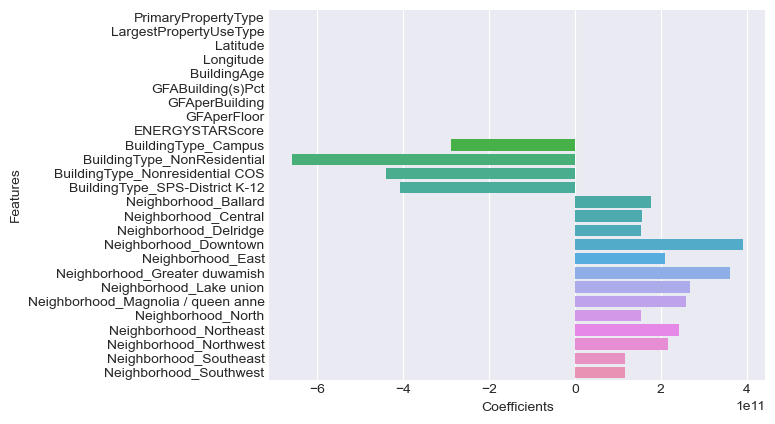

Time elapsed for building the Ridge model: 0.003492116928100586 seconds.
Coefficients du modèle Ridge


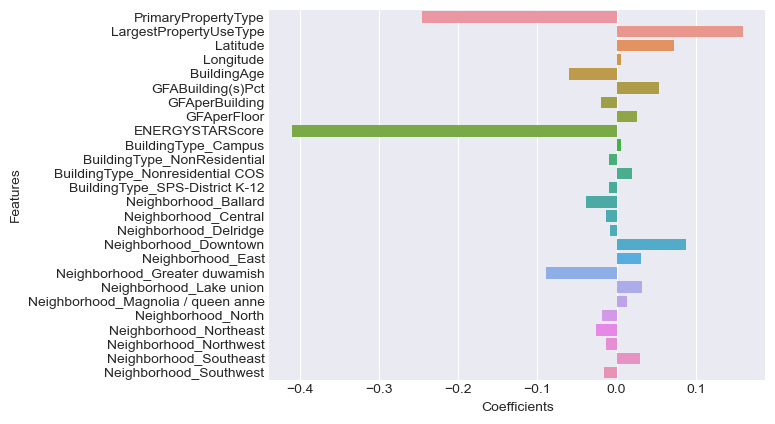

Time elapsed for building the Lasso model: 0.0012569427490234375 seconds.
Coefficients du modèle Lasso


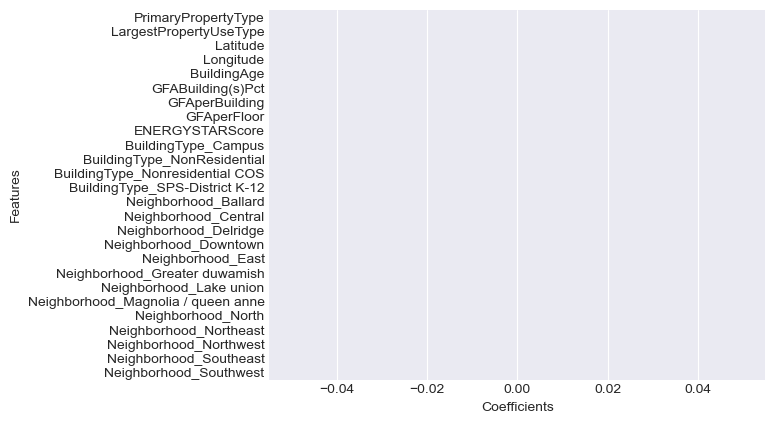

Time elapsed for building the Random Forest Regressor model: 0.31324219703674316 seconds.
Coefficients du modèle Random Forest Regressor


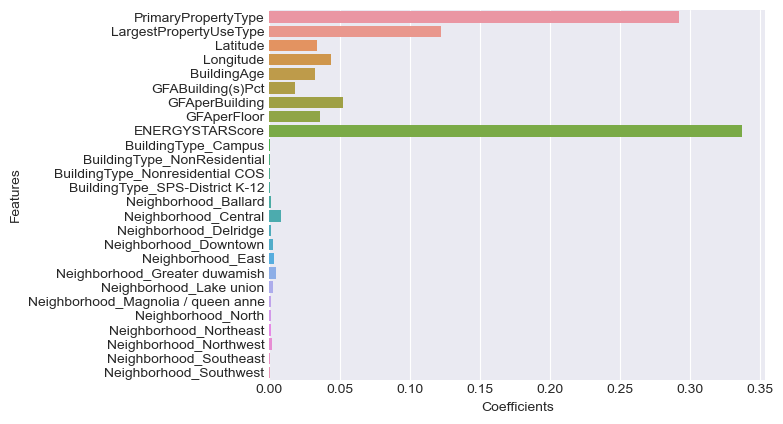

Time elapsed for building the Gradient Boosting Regressor model: 0.10503005981445312 seconds.
Coefficients du modèle Gradient Boosting Regressor


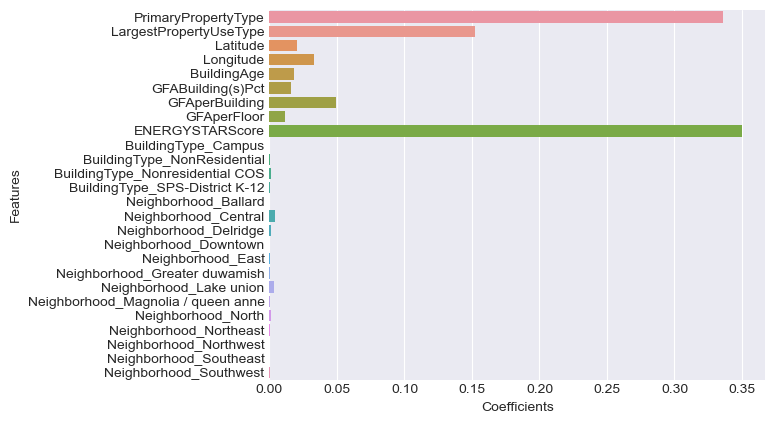

,Modele,R-squared (training set) [%],R-squared (test set) [%],RMSE [CO2e/MBtu],Computing time [s]
0,Linear Regression,38.595167,41.317204,0.610835,0.003524
1,Ridge,38.595072,41.292690,0.610963,0.003492
2,Lasso,0.000000,-0.133270,0.797918,0.001257
3,Random Forest Regressor,95.399664,67.682602,0.453301,0.313242
4,Gradient Boosting Regressor,86.637106,71.646842,0.424590,0.105030


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import time

from sklearn.metrics import mean_squared_error

seed=29

models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(random_state=seed),
          "Lasso": Lasso(random_state=seed),
          "Random Forest Regressor": RandomForestRegressor(random_state=seed),
          "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=seed)}

res = build_model(models, X_train_scaled, X_test_scaled, y_train, y_test, res)
res

En gardant la valeur par défaut de l'algo `Lasso()`, on remarque que tous les coefficients sont ramenés à 0. Avant d'optimiser les hyperparamètres, on veut s'assurer que l'algo a correctement été implémenté et pour cela, on va changer la valeur par defaut d'alpha en la diminuant.

R-square of the training set: 0.3817769493372969
R-square of the test set: 0.41507737076416007
RMSE: 0.6098430212954505
-----
[-0.21955289  0.12823156  0.01815607  0.         -0.05012486  0.05459561
 -0.          0.01196832 -0.39697077  0.         -0.          0.01654077
 -0.         -0.02540754 -0.0094903  -0.02052951  0.050175    0.01207706
 -0.12322792  0.01724891  0.         -0.         -0.00383686  0.
  0.00985121 -0.01991657]
Coefficients du modèle: Lasso(alpha=0.01)


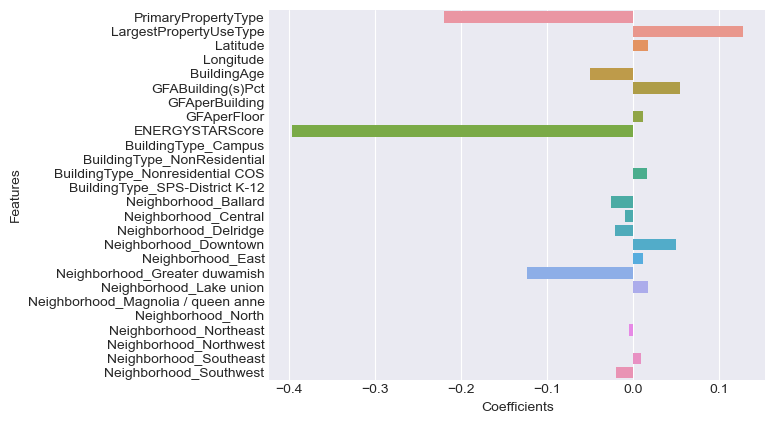

In [31]:
# On fit le modèle Lasso avec un autre alpha pour vérifier l'implémentation

model = Lasso(alpha=0.01)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
        
# R-squared or coef de détermination du training set
r_train = model.score(X_train_scaled, y_train)
print('R-square of the training set:', r_train)
        
# R-squared or coef de détermination du test set
r_test = model.score(X_test_scaled, y_test)
print('R-square of the test set:', r_test)
        
# RMSE of the model used
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

print('-----')
print(model.coef_)

# Print the coefficients of the model
coefficients = pd.DataFrame({'Features': X_cols, 'Coefficients': model.coef_})
            
# print(coefficients)
print('Coefficients du modèle:', model)
sns.barplot(data=coefficients, x='Coefficients', y='Features')
plt.show()

## Fitting with DummyRegressor for comparison

In [32]:
from sklearn.dummy import DummyRegressor

dr = DummyRegressor()

dr.fit(X_train_scaled, y_train)
y_pred = dr.predict(X_test_scaled)
        
r_train = dr.score(X_train_scaled, y_train)
print('R-square of the training set:', r_train)
        
r_test = dr.score(X_test_scaled, y_test)
print('R-square of the test set:', r_test)
        
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

R-square of the training set: 0.0
R-square of the test set: -0.0013326957011776663
RMSE: 0.7979176010130885


## Model optimization

In [33]:
# Fonction d'optimisation des modèles

def opt_model(model, hp_candidates, kfold, n_iter, scoring, 
              X_train_scaled, X_test_scaled, y_train, y_test, df):
    
    list_models = []
    best_estimator = []
    
    i=0
    
    for k, model in models.items():
        
#        hp = hp_candidates[k]
#        print(hp)
        #set a timer to calculate the computing time
        start_time = time.time()
        
        grid = RandomizedSearchCV(model, param_distributions=hp_candidates[k], cv=kfold,
                                  n_iter=n_iter, scoring=scoring, n_jobs = -1)
        grid.fit(X_train_scaled, y_train)
        
        #end of timer
        end_time = time.time() - start_time
        print('Time elapsed for building the', k, 'model:', end_time, 'seconds.')
        
        list_models.append(grid)
        best_estimator.append(grid.best_estimator_)
        
        model = grid.best_estimator_
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_test_scaled)
        
        # R-squared or coef de détermination du training set
        r_train = model.score(X_train_scaled, y_train)
        #print('R-square of the training set:', r_train)
        
        # R-squared or coef de détermination du test set
        r_test = model.score(X_test_scaled, y_test)
        #print('R-square of the test set:', r_test)
        
        # RMSE of the model used
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        #print('RMSE:', rmse)
        
        df.loc[df['Modele'] == k, 'Opti. R-squared (training set) [%]'] = r_train * 100
        df.loc[df['Modele'] == k, 'Opti. R-squared (test set) [%]'] = r_test * 100
        df.loc[df['Modele'] == k, 'Opti. RMSE [CO2e/MBtu]'] = rmse
        df.loc[df['Modele'] == k, 'Opti. computing time [s]'] = end_time
        
        i=i+1
        
    #print(best_estimator)
    
    return df, list_models, best_estimator
    

In [34]:
res["Opti. R-squared (training set) [%]"] = np.nan
res["Opti. R-squared (test set) [%]"] = np.nan
res["Opti. RMSE [CO2e/MBtu]"] = np.nan
res["Opti. computing time [s]"] = np.nan

In [35]:
from sklearn.model_selection import KFold, RandomizedSearchCV

# Create 3 folds
kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
n_alphas = 100
n_iter = 100
scoring = 'r2'
n = 50

# Number of alphas in regularization
alphas = np.linspace(0.001, 100, n_alphas)

# Number of trees
n_estimators = [int(x) for x in np.linspace(50, 1500, n)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 6, 8)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Learning rate for the boosting
learning_rate = np.linspace(0.05, 0.2, n)

models = {"Ridge": Ridge(random_state=seed), "Lasso": Lasso(random_state=seed),
          "Random Forest Regressor": RandomForestRegressor(random_state=seed),
          "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=seed)}

# hyperparamètres à optimiser pour les modèles Ridge et Lasso
hp_candidates_lr = [{'alpha': alphas}]
# hyperparamètres à optimiser pour le modèle Random Forest
hp_candidates_rf = [{'n_estimators': n_estimators, 'max_depth': max_depth, 'bootstrap': bootstrap}]
# hyperparamètres à optimiser pour le modèle Gradient Boosting
hp_candidates_gb = [{'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}]
# 2D dict avec les dicts des hyperparamètres de chaque modèle
hp_candidates = {"Ridge": hp_candidates_lr, "Lasso": hp_candidates_lr,
                 "Random Forest Regressor": hp_candidates_rf,
                 "Gradient Boosting Regressor": hp_candidates_gb}

res, list_models, best_estimators = opt_model(models, hp_candidates, kfold, n_iter, scoring,
                                              X_train_scaled, X_test_scaled, y_train, y_test, res)


Time elapsed for building the Ridge model: 1.8154988288879395 seconds.
Time elapsed for building the Lasso model: 0.10066509246826172 seconds.
Time elapsed for building the Random Forest Regressor model: 43.48662209510803 seconds.
Time elapsed for building the Gradient Boosting Regressor model: 27.602034330368042 seconds.


In [36]:
display(res)

,Modele,R-squared (training set) [%],R-squared (test set) [%],RMSE [CO2e/MBtu],Computing time [s],Opti. R-squared (training set) [%],Opti. R-squared (test set) [%],Opti. RMSE [CO2e/MBtu],Opti. computing time [s]
0,Linear Regression,38.595167,41.317204,0.610835,0.003524,NaN,NaN,NaN,NaN
1,Ridge,38.595072,41.292690,0.610963,0.003492,38.189836,40.433540,0.615417,1.815499
2,Lasso,0.000000,-0.133270,0.797918,0.001257,38.588131,41.354766,0.610640,0.100665
3,Random Forest Regressor,95.399664,67.682602,0.453301,0.313242,95.721871,68.937245,0.444415,43.486622
4,Gradient Boosting Regressor,86.637106,71.646842,0.424590,0.105030,79.513098,69.676266,0.439097,27.602034


In [37]:
best_estimators

[Ridge(alpha=59.59636363636364, random_state=29),
 Lasso(alpha=0.001, random_state=29),
 RandomForestRegressor(n_estimators=1322, random_state=29),
 GradientBoostingRegressor(learning_rate=0.056122448979591844, n_estimators=79,
                           random_state=29)]

## The attribute best_score_ contains the mean validation score over all splits of the best hyper-parameter setting

D'après l'optimisation du modèle, on voit que le modèle ayant le meilleur score R2 et le RMSE le plus faible est le `Gradient Boosting Regressor`. On va donc pouvoir utiliser les paramètres optimisés pour ce modèle dans la suite de notre projet.

In [38]:
gb = list_models[3].best_estimator_
gb.fit(X_train_scaled, y_train)

y_pred = gb.predict(X_test_scaled)

In [39]:
print('R-squared train set:', gb.score(X_train_scaled, y_train))
print('R-squared test set:', gb.score(X_test_scaled, y_test))
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

R-squared train set: 0.7951309799500591
R-squared test set: 0.6967626640763804
RMSE: 0.4390967097688958


# Model Explainability with LIME or SHAP

https://france.devoteam.com/paroles-dexperts/algorithme-n7-lime-ou-shap/

## 1. Fitting a multiple linear regression model

Explications rapides du LRM

Correlation measures the strength of the relationship between two variables, while R-squared measures the amount of variation in the data that is explained by the model.

The R-squared value, denoted by R2, is the square of the correlation. It measures the proportion of variation in the dependent variable that can be attributed to the independent variable. The R-squared value R2 is always between 0 and 1 inclusive. Perfect positive linear association.

https://www.analyticsvidhya.com/blog/2021/05/multiple-linear-regression-using-python-and-scikit-learn/#How_to_Train_a_Model_for_Multiple_Linear_Regression?

https://www.simplilearn.com/what-is-multiple-linear-regression-in-machine-learning-article

Explaining why the R2 can be negative

https://help.desmos.com/hc/en-us/articles/202529139-Why-am-I-seeing-a-negative-R-2-value-#:~:text=In%20practice%2C%20R2%20will,the%20mean%20of%20the%20data.

Le modèle de régression linéaire multiple n'est donc pas adéquat pour notre régression (R-squared sur notre set de test ne donne pas de résultat pertinent alors que notre R-squared sur notre training set nous informe que la variance de la variable cible est expliquée à 67% par les variables d'entrée).

## 2. Fitting with a Ridge model

Explications rapides du modèle Ridge

https://sparkbyexamples.com/machine-learning/ridge-regression-with-examples/

## 3. Fitting with a Lasso model

Explications rapides du modèle Lasso

https://sparkbyexamples.com/machine-learning/lasso-regression/

## X. Fitting with Kernel Ridge Regression

https://knork.medium.com/linear-regression-in-python-from-scratch-with-kernels-e9c37f7975b9

https://www.mdelcueto.com/blog/kernel-ridge-regression-tutorial/

## 5. Fitting with a Random Forests

https://medium.com/deep-math-machine-learning-ai/chapter-4-decision-trees-algorithms-b93975f7a1f1#:~:text=A%20decision%20tree%20is%20a,(categorical%20or%20continues%20value).

https://medium.com/@harshdeepsingh_35448/understanding-random-forests-aa0ccecdbbbb

https://towardsdatascience.com/random-forest-regression-5f605132d19d

## 6. Fitting with a Gradient Boost Regressor

https://towardsdatascience.com/all-you-need-to-know-about-gradient-boosting-algorithm-part-1-regression-2520a34a502

https://towardsdatascience.com/a-brief-introduction-to-xgboost-3eaee2e3e5d6#:~:text=XGBoost%20vs%20Gradient%20Boosting,can%20be%20parallelized%20across%20clusters.

# Annexes

### Pourquoi standardiser les variables d'entrée ?

https://www.atoti.io/articles/when-to-perform-a-feature-scaling/#:~:text=To%20ensure%20that%20the%20gradient,more%20quickly%20towards%20the%20minima.

https://mrmint.fr/data-preprocessing-feature-scaling-python

https://mrmint.fr/types-de-donnees-machine-learning

> Explication du Gradient Boost (l'algorithme derrière les modèles de ML pour minimiser la fonction coût : https://mrmint.fr/gradient-descent-algorithm

### Pourquoi scaler seulement sur le set d'entraînement et non sur le set de test ?

https://stats.stackexchange.com/questions/319514/why-feature-scaling-only-to-training-set

Not quite. You learn the means and standard deviation of the training set, and then:

Standardize the training set using the training set means and standard deviations.
Standardize any test set using the training set means and standard deviations.
This is just following the general principle: any thing you learn, must be learned from the model's training data.

But why not scaling full data beforehand (before train test split)? What will happen if I scale full data? – 

Because you have implicitly learned the mean of the testing data by including it in your calculation. If you want to test your model honestly, you can't look at the target in your testing data in any part of constructing the model. Remember, when your model is in production, you won't even know the target in your data. – 

### Comment sélectionner le bon modèle de Machine Learning ?

https://pianalytix.com/factors-to-consider-to-select-ml-algorithms/#:~:text=Selection%20of%20model%20depends%20upon,%2C%20number%20of%20observations%2C%20etc.

https://u-next.com/blogs/machine-learning/popular-regression-algorithms-ml/#:~:text=7)%20KNN%20Model,to%20the%20existing%20data%20points.

### Comprendre KNN pour la régression (KNN Regressor)

https://towardsdatascience.com/the-basics-knn-for-classification-and-regression-c1e8a6c955

## Tuning hparam with CV

https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/#

https://www.projectpro.io/recipes/find-optimal-parameters-using-randomizedsearchcv-for-regression

Les 10 algos de ML les plus utilisés pour la régression :

https://u-next.com/blogs/machine-learning/popular-regression-algorithms-ml/

Autres articles intéressants sur la modélisation des modèles de ML :

https://dev.to/mage_ai/10-steps-to-build-and-optimize-a-ml-model-4a3h

https://www.datacamp.com/blog/machine-learning-models-explained

https://www.datacamp.com/tutorial/parameter-optimization-machine-learning-models